y_test_predict = rf.predict(X_test)y_test_predict = rf.predict(X_test)y_test_predict = rf.predict(X_test)y_test_predict = rf.predict(X_test)y_test_predict = rf.predict(X_test)## Credit Card Consumption Prediction 信用卡消費預測
- 以此三個月的資料預測未來三個月的信用卡消費。

### 預測
- 信用卡在未來三個月內的平均花費 (cc_cons)

### 特徵定義
- id &rArr; 每個客戶的唯一ID
- account_type &rArr; 帳戶類型 - [活期帳戶&rArr;Current accounts] 或 [儲蓄帳戶：Saving accounts]
- gender &rArr; 客戶的性別
- age &rArr; 客戶的年齡
- region_code &rArr; 要求居住地區（有訂單）
- cc_cons_apr &rArr; 信用卡credit card 在 4月份花費
- dc_cons_apr &rArr; 金融卡(簽帳金融卡)Debit Card 在 4月份花費
- cc_cons_may &rArr; 信用卡credit card 在 5月份花費
- dc_cons_may &rArr; 金融卡Debit Card 在 5月份花費
- cc_cons_jun &rArr; 信用卡credit card 在 6月份花費
- dc_cons_jun &rArr; 金融卡Debit Card 在 6月份花費
- cc_count_apr &rArr; 信用卡credit card 在 4月份交易數量
- cc_count_may &rArr; 信用卡credit card 在 5月份交易數量
- cc_count_jun &rArr; 信用卡credit card 在 6月份交易數量
- dc_count_apr &rArr; 金融卡Debit Card 在 4月份交易數量
- dc_count_may &rArr; 金融卡Debit Card 在 5月份交易數量
- dc_count_jun &rArr; 金融卡Debit Card 在 6月份交易數量
- card_lim &rArr; 信用卡最大限制金額
- personal_loan_active &rArr; 與其他銀行有效的個人貸款
- vehicle_loan_active &rArr; 與其他銀行有效的車輛貸款
- personal_loan_closed &rArr; 在過去12個月內關閉個人貸款
- vehicle_loan_closed &rArr; 過去12個月的關閉車輛貸款
- investment_1 &rArr; 6月的DEMAT投資
- investment_2 &rArr; 6月份固定存款投資
- investment_3 &rArr; 6月的人壽保險投資
- investment_4 &rArr; 6月一般保險投資
- debit_amount_apr &rArr; 4月份借記的總金額
- credit_amount_apr &rArr; 4月份貸記的總金額
- debit_count_apr &rArr; 4月借記的總次數
- credit_count_apr &rArr; 4月貸記的總次數
- max_credit_amount_apr &rArr; 4月份最高金額
- debit_amount_may &rArr; 5月份借記的總金額
- credit_amount_may &rArr; 5月份貸記的總金額
- credit_count_may &rArr; 5月份貸記的總次數
- debit_count_may &rArr; 5月份借記的總次數
- max_credit_amount_may &rArr; 5月份最高金額
- debit_amount_jun &rArr; 6月借記​​的總金額
- credit_amount_jun &rArr; 6月總金額
- credit_count_jun &rArr; 6月份貸記的總次數
- debit_count_jun &rArr; 6月份借記的總次數
- max_credit_amount_jun &rArr; 6月份的最高金額
- loan_enq &rArr; 過去3個月的貸款詢問
- emi_active &rArr; 每月EMI支付給其他銀行有效貸款 (EMI:每月分期付款)
- cc_cons &rArr; （目標）接下來三個月的平均信用卡花費


In [401]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder # 用於特徵提取, 將數值資料轉為離散

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format','{:}'.format)
# 數值顯示至小數點後第二位
pd.set_option('display.precision',2)

In [402]:
# 載入資料集
dataset = pd.read_csv('./data/Credit Card Consumption Prediction/Credit_Card_Consumption_Prediction.csv', encoding='utf8')
dataset.head()

,id,account_type,gender,age,region_code,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons
0,23334,saving,M,63,305,7695.0,NaN,479.0,NaN,622.0,NaN,2.0,1.0,3.0,NaN,NaN,NaN,150000.0,NaN,NaN,NaN,NaN,NaN,118845.2,50000.0,NaN,51205.47,50259.0,3.0,1.0,50000.0,24740.22,114252.0,3.0,2.0,45000.0,20215.85,1279.37,7.0,3.0,470.0,NaN,0.0,435
1,20329,current,M,33,326,52702.0,988.72,29873.0,NaN,1087.0,2806.24,11.0,14.0,11.0,1.0,NaN,6.0,176000.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,159050.76,169812.0,20.0,9.0,70000.0,103102.85,174606.0,6.0,10.0,150000.0,122037.66,55390.0,8.0,19.0,27000.0,NaN,4963.33,1921
2,17679,current,M,44,264,10800.49,3215.52,21660.0,1607.0,1168.0,355.0,6.0,9.0,6.0,3.0,2.0,14.0,65000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51484.55,38942.0,16.0,4.0,11700.0,15283.0,23051.0,2.0,7.0,13800.0,46827.0,29297.91,6.0,19.0,20800.0,NaN,0.0,1970
3,16428,saving,M,44,233,20936.0,NaN,2094.0,NaN,11778.5,NaN,9.0,6.0,6.0,NaN,NaN,NaN,600000.0,NaN,NaN,NaN,NaN,NaN,132442.0,NaN,NaN,1981.07,2294.0,2.0,1.0,2000.0,19361.24,19529.0,1.0,1.0,19300.0,5426.55,7544.0,3.0,1.0,5300.0,NaN,1238.18,21579
4,18721,saving,F,35,324,1183.83,NaN,3656.29,NaN,945.0,NaN,2.0,7.0,9.0,NaN,NaN,NaN,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6462.0,10271.0,6.0,1.0,10000.0,7461.0,3194.0,2.0,3.0,3000.0,26178.05,53483.0,4.0,4.0,45000.0,NaN,0.0,1814


aaa = dataset[dataset['id']==23334]
aaa

#### 觀察資料
> 移除明顯無法作為特徵的欄位
> id、region_code

In [404]:
# 移除 ID 欄位
dataset.drop("id", axis=1, inplace=True)
dataset.drop("region_code", axis=1, inplace=True)

# 確認資料特徵類型
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32820 entries, 0 to 32819
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   account_type           32820 non-null  object 
 1   gender                 32820 non-null  object 
 2   age                    32820 non-null  int64  
 3   cc_cons_apr            32820 non-null  float64
 4   dc_cons_apr            13768 non-null  float64
 5   cc_cons_may            32820 non-null  float64
 6   dc_cons_may            15481 non-null  float64
 7   cc_cons_jun            32820 non-null  float64
 8   dc_cons_jun            11523 non-null  float64
 9   cc_count_apr           30421 non-null  float64
 10  cc_count_may           31667 non-null  float64
 11  cc_count_jun           31230 non-null  float64
 12  dc_count_apr           13768 non-null  float64
 13  dc_count_may           15481 non-null  float64
 14  dc_count_jun           17323 non-null  float64
 15  ca

#### 檢查缺失值 Missing Value

Text(0.5, 1.0, '資料集中的缺失值數量')

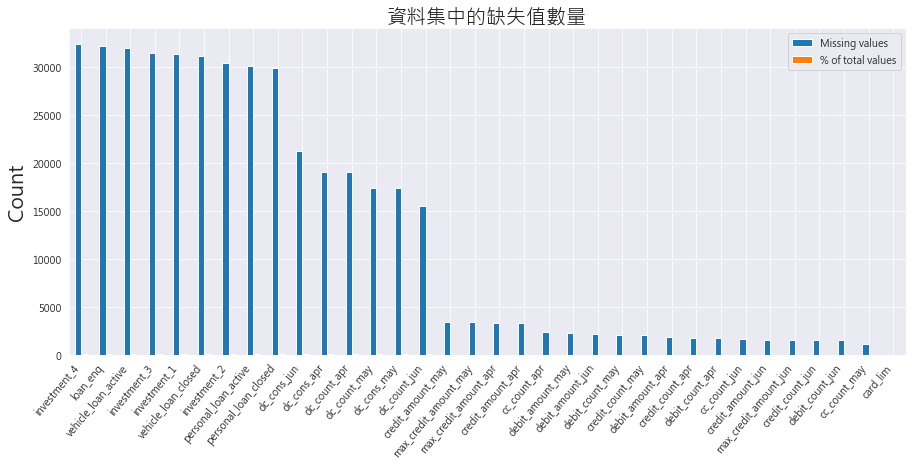

In [405]:
# 定義缺失值檢測函數
def missing_value_table(df):
    
    # 計算所有的缺失值
    mis_val = df.isnull().sum()
    
    # 佔 % 比
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # 合併
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # 給予合併的表格 每個column各一個新名字
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values', 1:'% of total values'})
    
    # 剔除沒有缺失值的 並 排序
    # 判斷所有數據中的第一 row .iloc[:,1]!=0] 不等於 0的 
    # .iloc[:,1] 代表Missing value 那個 column
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('Missing values',ascending=False)
    
    return mis_val_rename

missing_value_table(dataset).plot(kind="bar", figsize = (15,6), fontsize = 10)
plt.xticks(rotation=50, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("資料集中的缺失值數量", fontsize = 20)

#### 填補缺失值 Missing Value 
> - investment_4 ~ investment_1 (一般保險投資) : 判斷空值即為沒有投資，補 0  
> - loan_enq (過去3個月的貸款詢問) : 沒有問貸款 就是 N (此特徵為object，Y 或 N)  
> - vehicle_loan_active、vehicle_loan_closed (車貸) : 沒有就補 0，非1即0 
> - personal_loan_active、personal_loan_closed (貸款) : 沒有就補 0，非1即0
> - dc_cons_jun、cc_count_jun...等 (信用卡與扣帳卡的花費與交易數量) : 沒有資料意味可能無交易，因此補 0
> - credit_amount_may、credit_count_may...等 (借貸的金額) : 發現如果交易次數(count)為0，則交易金額(amount)是空的，因此補 0
> - card_lim (信用卡最大限制金額) :  怕有些超有錢的大佬拉高平均，因此用眾數來填補平均值

In [406]:

# 投資補 0
dataset['investment_4'] = dataset['investment_4'].fillna(0)
dataset['investment_3'] = dataset['investment_3'].fillna(0)
dataset['investment_2'] = dataset['investment_2'].fillna(0)
dataset['investment_1'] = dataset['investment_1'].fillna(0)
# 是否有問貸款 缺值補 N 
dataset['loan_enq'] = dataset['loan_enq'].fillna('N')
# 車貸 沒有就補 0
dataset['vehicle_loan_active'] = dataset['vehicle_loan_active'].fillna(0)
dataset['vehicle_loan_closed'] = dataset['vehicle_loan_closed'].fillna(0)
# 個人貸款貸 沒有就補 0
dataset['personal_loan_active'] = dataset['personal_loan_active'].fillna(0)
dataset['personal_loan_closed'] = dataset['personal_loan_closed'].fillna(0)
# 信用卡與扣帳卡的花費與交易數量 沒有就補 0
dataset['dc_cons_jun'] = dataset['dc_cons_jun'].fillna(0)
dataset['dc_cons_apr'] = dataset['dc_cons_apr'].fillna(0)
dataset['dc_cons_may'] = dataset['dc_cons_may'].fillna(0)
dataset['dc_count_jun'] = dataset['dc_count_jun'].fillna(0)
dataset['dc_count_apr'] = dataset['dc_count_apr'].fillna(0)
dataset['dc_count_may'] = dataset['dc_count_may'].fillna(0)
dataset['cc_count_apr'] = dataset['cc_count_apr'].fillna(0)
dataset['cc_count_jun'] = dataset['cc_count_jun'].fillna(0)
dataset['cc_count_may'] = dataset['cc_count_may'].fillna(0)
# 借貸的金額
dataset['credit_amount_may'] = dataset['credit_amount_may'].fillna(0)
dataset['credit_amount_apr'] = dataset['credit_amount_apr'].fillna(0)
dataset['debit_amount_may'] = dataset['debit_amount_may'].fillna(0)
dataset['debit_amount_jun'] = dataset['debit_amount_jun'].fillna(0)
dataset['debit_amount_apr'] = dataset['debit_amount_apr'].fillna(0)
dataset['credit_amount_jun'] = dataset['credit_amount_jun'].fillna(0)
dataset['debit_count_may'] = dataset['debit_count_may'].fillna(0)
dataset['credit_count_may'] = dataset['credit_count_may'].fillna(0)
dataset['credit_count_jun'] = dataset['credit_count_jun'].fillna(0)
dataset['debit_count_jun'] = dataset['debit_count_jun'].fillna(0)
dataset['credit_count_apr'] = dataset['credit_count_apr'].fillna(0)
dataset['debit_count_apr'] = dataset['debit_count_apr'].fillna(0)
dataset['max_credit_amount_may'] = dataset['max_credit_amount_may'].fillna(0)
dataset['max_credit_amount_apr'] = dataset['max_credit_amount_apr'].fillna(0)
dataset['max_credit_amount_jun'] = dataset['max_credit_amount_jun'].fillna(0)
# 信用卡最大限制金額 使用眾數 mode 來填補
dataset['card_lim'] = dataset['card_lim'].fillna(dataset['card_lim'].mode()[0])

# try:
#     missing_value_table(dataset).plot(kind="bar", figsize = (15,6), fontsize = 10)
#     plt.xticks(rotation=50, ha='right')
#     plt.ylabel("Count", fontsize = 20)
#     plt.title("資料集中的缺失值數量", fontsize = 20)
# except:
#     print("無缺失值")

#### 異常值檢查與處理 outlier
> - 直接使用四分位樹間距判斷會取得過多的異常值，有可能是因為貧富差距導致交易習性不同，因此排除此方法  

> - investment_4 (一般保險投資): 發現最小值有負數的 , 將他轉正  
> - age : 發現部分人年紀超過 100 歲 , 取平均數補值
> - cc_cons & dc_cons : 花費無法判斷是否合理，可能有土豪  
> - 檢查信用卡 (credit card) 花費是否大於信用卡限制金額上限 , 將所有超過上限的人用上限的金額補值  
> - 金融卡 (debit card) 無法判斷她戶頭有多少錢，因此他花的再多都有可能
> - 信用卡與金融卡的交易次數，單月竟然可以超過30次，有可能是狂刷卡的人，假設正常
> - 最大信用卡金額不可能超過金額限制，因此使用金額限制補值

In [407]:
# 觀察資料分布
dataset.describe()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
count,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0
mean,35.95167580743449,16661.9071889092,2402.7365886654475,14411.904569165144,2658.2352949421083,9031.179889092014,1638.4685783059113,8.49247410115783,9.205027422303473,11.702864107251676,2.205271176112127,2.956398537477148,4.16819012797075,121547.83912248629,0.08354661791590494,0.025776965265082268,0.08784277879341865,0.04951249238269348,35259.47127696832,12576.6112992078,1613.5731175015235,61.51409873430835,65996.94655210237,67824.75468403414,14.089853747714809,3.588665447897623,41795.70081261426,62392.08801310176,71335.82882145034,3.829433272394881,13.055484460694698,44540.9459290067,72407.06138848265,72269.99170505788,5.4992078001218765,15.256459475929312,42639.97693205363,9567.6197440585,6824.631840341255
std,8.529948884163367,25138.435416228534,7993.217055846619,23636.877823497023,10052.661574784013,15720.847306935439,6477.366588631065,10.659068682639962,9.63878116113866,11.72811260221401,4.751877233926239,5.956464249458118,7.7584570517709945,123003.47513715427,0.27671088440149294,0.15847169623931445,0.2830704266994653,0.2169387919134205,935513.230058002,125966.28921487468,18703.289710048128,873.147187124584,160229.14864389188,170062.29473161706,11.762698329022326,3.4936400344991685,112909.22303393304,179729.24008277644,193414.40861887258,3.8547043292983156,11.593995461424496,122803.6905567435,303946.54415160744,299423.0555317333,4.75189932824527,13.483519841255063,119023.79090582705,261673.64792667908,12459.14059251958
min,22.0,233.97,0.0,103.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,31.0,3712.0,0.0,2983.2975,0.0,1637.875,0.0,2.0,3.0,4.0,0.0,0.0,0.0,45000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18965.9725,20010.75,5.0,1.0,14743.75,16366.349999999999,18133.75,1.0,5.0,13578.6275,21001.235,20323.75,3.0,6.0,14634.25,0.0,1285.0
50%,34.0,8912.79,0.0,7332.297500000001,0.0,4147.4875,0.0,6.0,7.0,9.0,0.0,0.0,1.0,75000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38516.625,39240.5,12.0,3.0,25300.0,35106.259999999995,40012.5,3.0,10.0,26512.0,42266.0,40527.645000000004,4.0,12.0,25500.0,151.065,3141.0
75%,39.0,19932.06,1582.5,16847.85,1888.25,10126.25,857.0,12.0,13.0,16.0,2.0,3.0,5.0,145000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72071.5375,73472.38,20.0,5.0,44700.0,69460.7025,81230.5,5.0,18.0,49000.0,79782.09999999999,77699.36,7.0,21.0,45060.5,4176.8675,7349.25
max,224.0,804712.58,366223.16,1117246.31,911223.49,382914.1,301991.94,1012.0,601.0,653.0,82.0,97.0,104.0,1000000.0,1.0,1.0,1.0,1.0,84452225.0,13602841.6,1650000.0,35346.0,13535711.75,13100583.0,147.0,78.0,12029154.0,22301215.19,22463497.92,71.0,171.0,12851029.85,39868810.0,39339313.35,117.0,164.0,12932377.08,44687220.7,408630.0


In [408]:
# 發現投資有負數，給他取絕對值
dataset['investment_4'] = abs(dataset['investment_4'])

# 使用平均值取代年紀超過100歲的人
dataset.loc[dataset['age'] > 100 ,'age'] = dataset['age'].mean()

# 花費超過信用卡上限的人 直接用上限 card_lim 補值
dataset.loc[dataset['cc_cons_apr'] > dataset['card_lim'],'cc_cons_apr'] = dataset['card_lim']
dataset.loc[dataset['cc_cons_may'] > dataset['card_lim'],'cc_cons_may'] = dataset['card_lim']
dataset.loc[dataset['cc_cons_jun'] > dataset['card_lim'],'cc_cons_jun'] = dataset['card_lim']

# 當月最高消費金額，使用最大金額限制補值
dataset.loc[dataset['max_credit_amount_apr'] > dataset['card_lim'],'max_credit_amount_apr'] = dataset['card_lim']
dataset.loc[dataset['max_credit_amount_may'] > dataset['card_lim'],'max_credit_amount_may'] = dataset['card_lim']
dataset.loc[dataset['max_credit_amount_jun'] > dataset['card_lim'],'max_credit_amount_jun'] = dataset['card_lim']

In [409]:
dataset.describe()

,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,cc_cons
count,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0,32820.0
mean,35.850237413016025,16475.559240249848,2402.7365886654475,14251.637315204143,2658.2352949421083,8990.822003351614,1638.4685783059113,8.49247410115783,9.205027422303473,11.702864107251676,2.205271176112127,2.956398537477148,4.16819012797075,121547.83912248629,0.08354661791590494,0.025776965265082268,0.08784277879341865,0.04951249238269348,35259.47127696832,12576.6112992078,1613.5731175015235,73.01667518403413,65996.94655210237,67824.75468403414,14.089853747714809,3.588665447897623,34789.75681596588,62392.08801310176,71335.82882145034,3.829433272394881,13.055484460694698,35863.95636471663,72407.06138848265,72269.99170505788,5.4992078001218765,15.256459475929312,35077.29690615479,9567.6197440585,6824.631840341255
std,7.571079522460452,24001.791403058127,7993.217055846619,22445.062237721944,10052.661574784013,15452.963223565836,6477.366588631065,10.659068682639962,9.63878116113866,11.72811260221401,4.751877233926239,5.956464249458118,7.7584570517709945,123003.47513715427,0.27671088440149294,0.15847169623931445,0.2830704266994653,0.2169387919134205,935513.230058002,125966.28921487468,18703.289710048128,872.2605761586848,160229.14864389188,170062.29473161706,11.762698329022326,3.4936400344991685,43095.389014791566,179729.24008277644,193414.40861887258,3.8547043292983156,11.593995461424496,43505.48175417955,303946.54415160744,299423.0555317333,4.75189932824527,13.483519841255063,42644.487912966484,261673.64792667908,12459.14059251958
min,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,31.0,3710.23,0.0,2981.0,0.0,1636.9375,0.0,2.0,3.0,4.0,0.0,0.0,0.0,45000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18965.9725,20010.75,5.0,1.0,14620.25,16366.349999999999,18133.75,1.0,5.0,13500.0,21001.235,20323.75,3.0,6.0,14513.25,0.0,1285.0
50%,34.0,8911.795,0.0,7330.93,0.0,4146.5,0.0,6.0,7.0,9.0,0.0,0.0,1.0,75000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38516.625,39240.5,12.0,3.0,25000.0,35106.259999999995,40012.5,3.0,10.0,25550.0,42266.0,40527.645000000004,4.0,12.0,25000.0,151.065,3141.0
75%,39.0,19891.7625,1582.5,16830.737500000003,1888.25,10124.5,857.0,12.0,13.0,16.0,2.0,3.0,5.0,145000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72071.5375,73472.38,20.0,5.0,41547.75,69460.7025,81230.5,5.0,18.0,45000.0,79782.09999999999,77699.36,7.0,21.0,42000.0,4176.8675,7349.25
max,71.0,565784.55,366223.16,800000.0,911223.49,348075.7,301991.94,1012.0,601.0,653.0,82.0,97.0,104.0,1000000.0,1.0,1.0,1.0,1.0,84452225.0,13602841.6,1650000.0,35346.0,13535711.75,13100583.0,147.0,78.0,1000000.0,22301215.19,22463497.92,71.0,171.0,1000000.0,39868810.0,39339313.35,117.0,164.0,1000000.0,44687220.7,408630.0


### EDA (Exploratory Data Analysis) 探索式資料分析
> - 先用 displot 與 describe 觀察資料分布  
> - 觀察年紀與消費的關係: 明顯看出,年紀越大消費能力越大 
> - 觀察性別與消費的關係: 女生似乎比較會花錢 (沒有性別歧視!!)
> - 觀察貸款諮詢與消費的關係: 有貸款需求的人, 消費力似乎低了一點點
> - 觀察信用卡 & 金融卡單月消費金額 : 信用卡消費金額明顯大於金融卡, 六月消費力下降
> - 觀察信用卡 & 金融卡單月交易次數 : 交易次數越高, 竟然消費金額越低, 這是什麼原因
> - 觀察投資金額與信用卡消費的關係 : 投資金額越高, 信用卡消費力越低
> - 借記與貸記總金額與信用卡消費的關係 : 

<AxesSubplot:xlabel='cc_cons', ylabel='Density'>

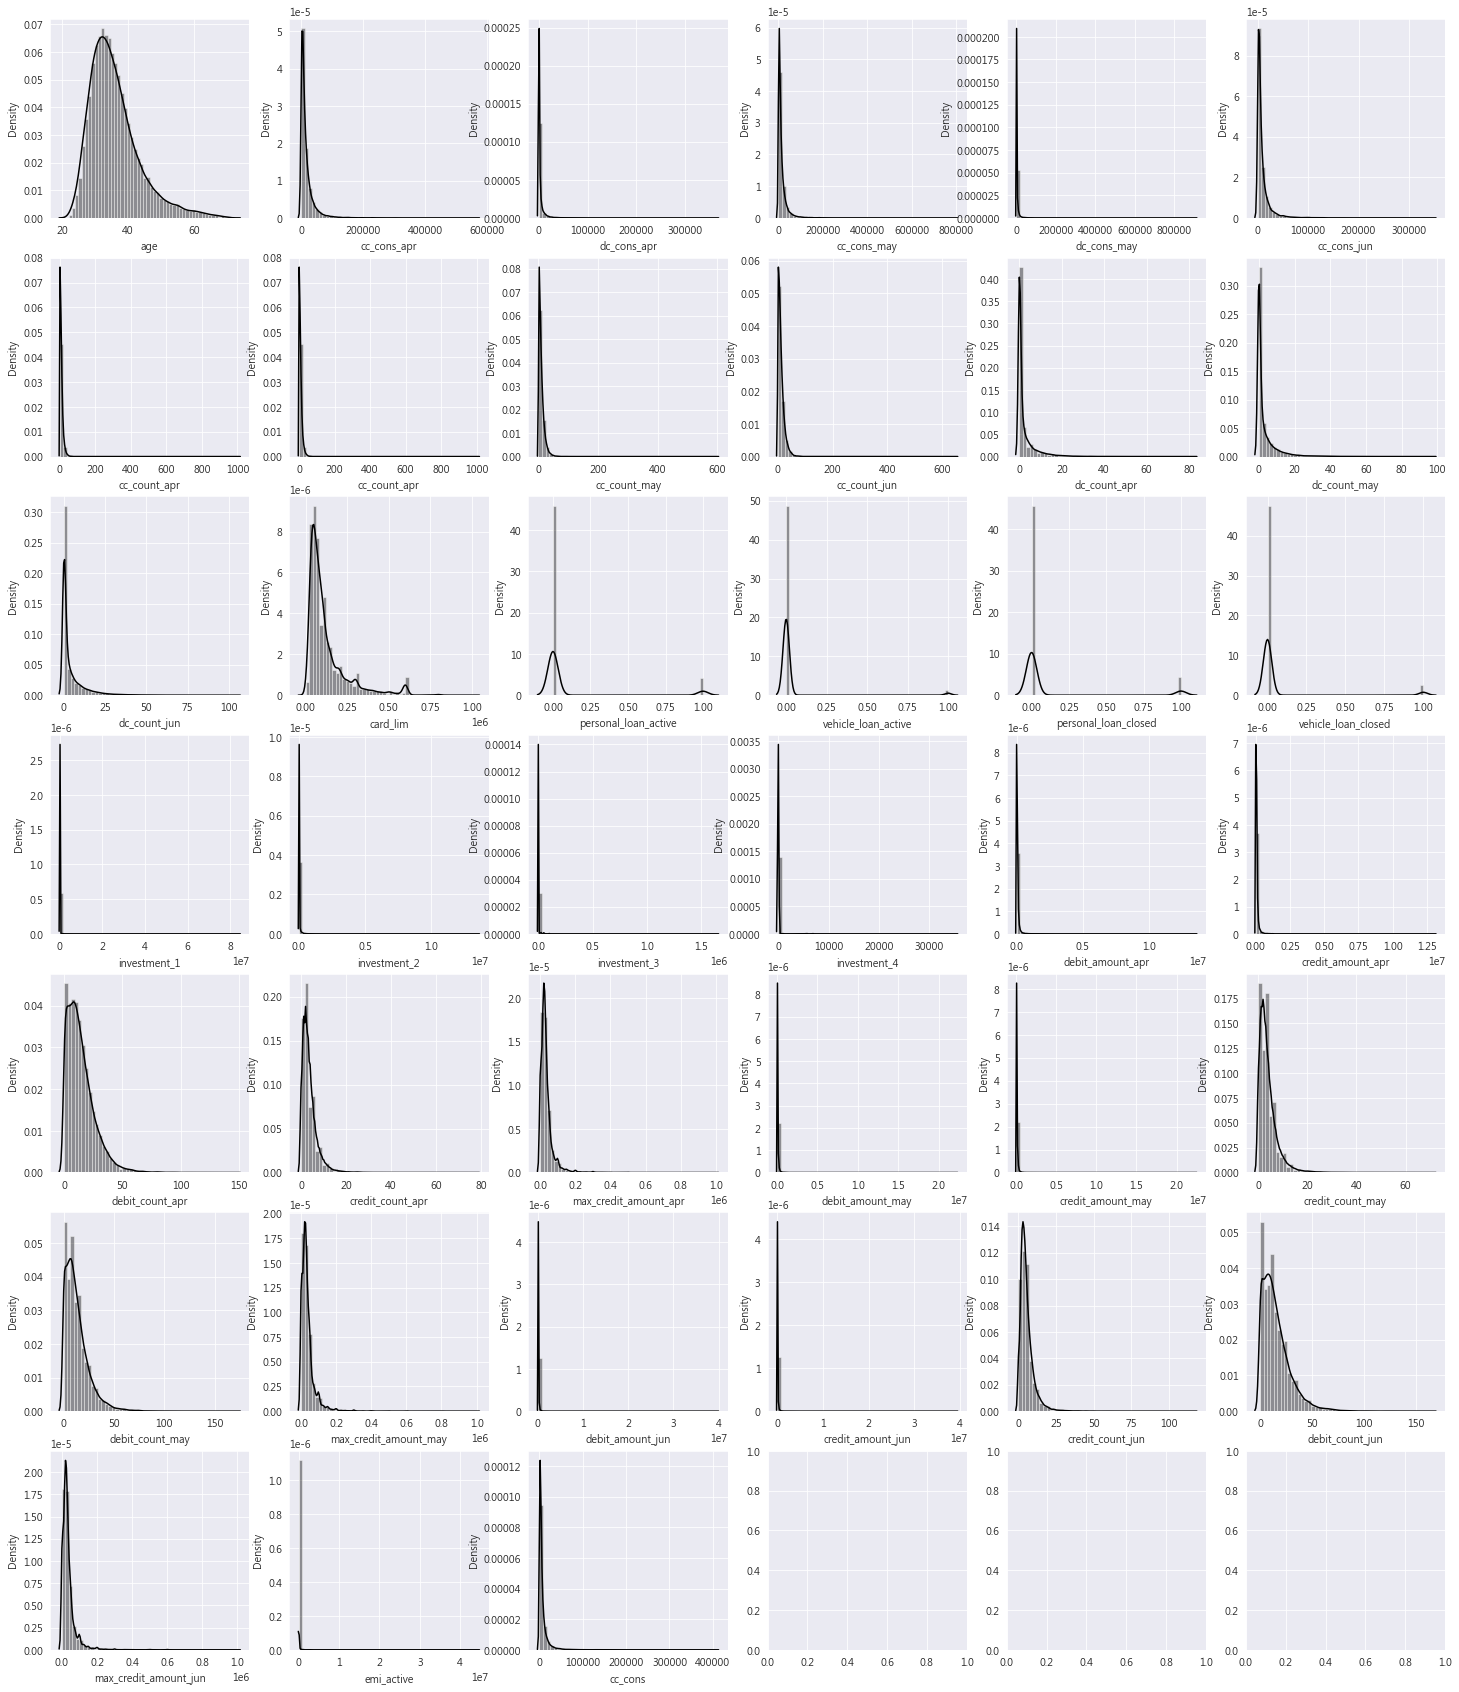

In [410]:
# 觀察所有人的核密度直方圖 查看分布
f, ax = plt.subplots(7, 6, figsize=(25, 30))

sns.distplot(dataset['age'], ax = ax[0, 0], color = 'k')
sns.distplot(dataset['cc_cons_apr'], ax = ax[0, 1], color = 'k')
sns.distplot(dataset['dc_cons_apr'], ax = ax[0, 2], color = 'k')
sns.distplot(dataset['cc_cons_may'], ax = ax[0, 3], color = 'k')
sns.distplot(dataset['dc_cons_may'], ax = ax[0, 4], color = 'k')
sns.distplot(dataset['cc_cons_jun'], ax = ax[0, 5], color = 'k')
sns.distplot(dataset['cc_count_apr'], ax = ax[1, 0], color = 'k')
sns.distplot(dataset['cc_count_apr'], ax = ax[1, 1], color = 'k')
sns.distplot(dataset['cc_count_may'], ax = ax[1, 2], color = 'k')
sns.distplot(dataset['cc_count_jun'], ax = ax[1, 3], color = 'k')
sns.distplot(dataset['dc_count_apr'], ax = ax[1, 4], color = 'k')
sns.distplot(dataset['dc_count_may'], ax = ax[1, 5], color = 'k')
sns.distplot(dataset['dc_count_jun'], ax = ax[2, 0], color = 'k')
sns.distplot(dataset['card_lim'], ax = ax[2, 1], color = 'k')
sns.distplot(dataset['personal_loan_active'], ax = ax[2, 2], color = 'k')
sns.distplot(dataset['vehicle_loan_active'], ax = ax[2, 3], color = 'k')
sns.distplot(dataset['personal_loan_closed'], ax = ax[2, 4], color = 'k')
sns.distplot(dataset['vehicle_loan_closed'], ax = ax[2, 5], color = 'k')
sns.distplot(dataset['investment_1'], ax = ax[3, 0], color = 'k')
sns.distplot(dataset['investment_2'], ax = ax[3, 1], color = 'k')
sns.distplot(dataset['investment_3'], ax = ax[3, 2], color = 'k')
sns.distplot(dataset['investment_4'], ax = ax[3, 3], color = 'k')
sns.distplot(dataset['debit_amount_apr'], ax = ax[3, 4], color = 'k')
sns.distplot(dataset['credit_amount_apr'], ax = ax[3, 5], color = 'k')
sns.distplot(dataset['debit_count_apr'], ax = ax[4, 0], color = 'k')
sns.distplot(dataset['credit_count_apr'], ax = ax[4, 1], color = 'k')
sns.distplot(dataset['max_credit_amount_apr'], ax = ax[4, 2], color = 'k')
sns.distplot(dataset['debit_amount_may'], ax = ax[4, 3], color = 'k')
sns.distplot(dataset['credit_amount_may'], ax = ax[4, 4], color = 'k')
sns.distplot(dataset['credit_count_may'], ax = ax[4, 5], color = 'k')
sns.distplot(dataset['debit_count_may'], ax = ax[5, 0], color = 'k')
sns.distplot(dataset['max_credit_amount_may'], ax = ax[5, 1], color = 'k')
sns.distplot(dataset['debit_amount_jun'], ax = ax[5, 2], color = 'k')
sns.distplot(dataset['credit_amount_jun'], ax = ax[5, 3], color = 'k')
sns.distplot(dataset['credit_count_jun'], ax = ax[5, 4], color = 'k')
sns.distplot(dataset['debit_count_jun'], ax = ax[5, 5], color = 'k')
sns.distplot(dataset['max_credit_amount_jun'], ax = ax[6, 0], color = 'k')
sns.distplot(dataset['emi_active'], ax = ax[6, 1], color = 'k')
sns.distplot(dataset['cc_cons'], ax = ax[6, 2], color = 'k')

<AxesSubplot:xlabel='age_binned', ylabel='cc_cons'>

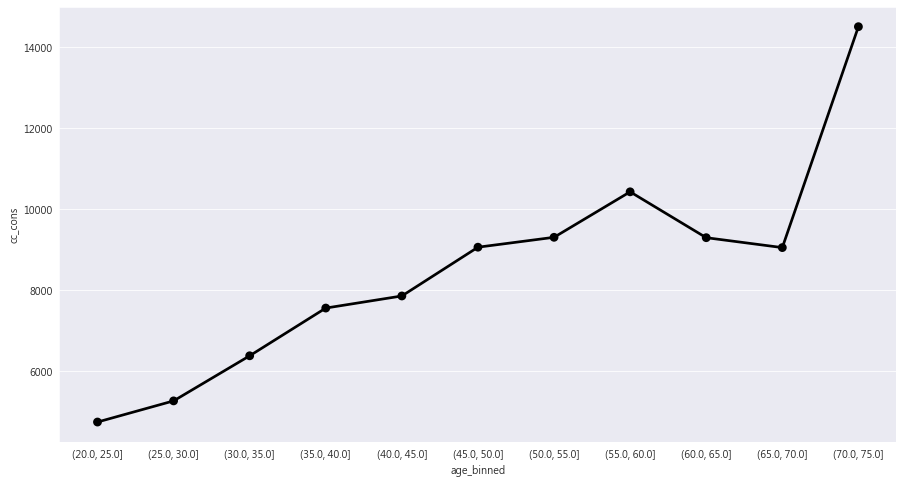

In [411]:
# 先把年齡分成區間, 判斷消費能力
# 針對 消費 跟 年紀 做一個 dataframe
age_data = dataset[['cc_cons','age']]
age_data['age_binned'] = pd.cut(age_data['age'], bins = np.linspace(20, 75, num=12))
age_groups = age_data.groupby('age_binned').mean()
age_groups.reset_index()
plt.figure(figsize=(15,8))
sns.pointplot(data = age_groups.reset_index(), x="age_binned", y="cc_cons", color = 'k')

# plt.xticks(rotation=30)

<AxesSubplot:xlabel='gender', ylabel='cc_cons'>

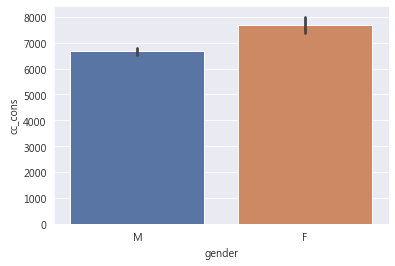

In [412]:
# 性別 vs 信用卡消費 
sns.barplot(data = dataset, x="gender" , y="cc_cons", palette='deep')

<AxesSubplot:xlabel='loan_enq', ylabel='cc_cons'>

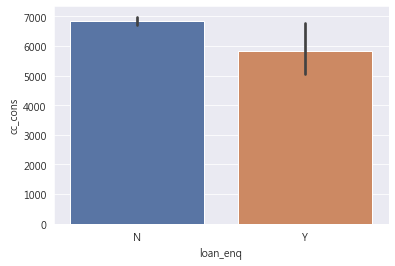

In [413]:
# 貸款詢問 vs 信用卡消費 
sns.barplot(data = dataset, x="loan_enq" , y="cc_cons", palette='deep')

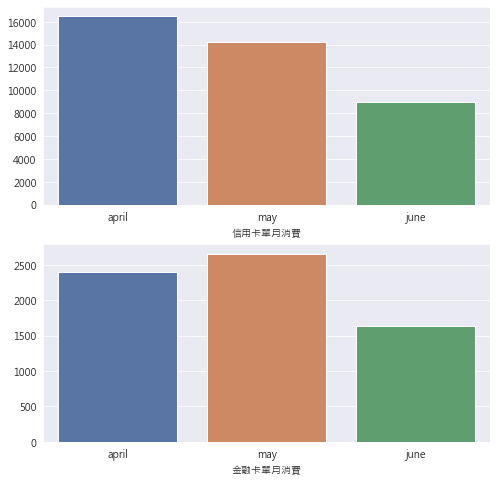

In [414]:
# 觀察信用卡 & 金融卡單月消費 [金額]
plt.figure(figsize=(8,8))

plt.subplot(211)
sns.barplot(x=["april", "may", "june"],y=[dataset["cc_cons_apr"].mean(),dataset['cc_cons_may'].mean(),dataset["cc_cons_jun"].mean()], palette='deep')
plt.xlabel('信用卡單月消費')

plt.subplot(212)
sns.barplot(x=["april", "may", "june"],y=[dataset["dc_cons_apr"].mean(),dataset['dc_cons_may'].mean(),dataset["dc_cons_jun"].mean()], palette='deep')
plt.xlabel('金融卡單月消費')

plt.show()

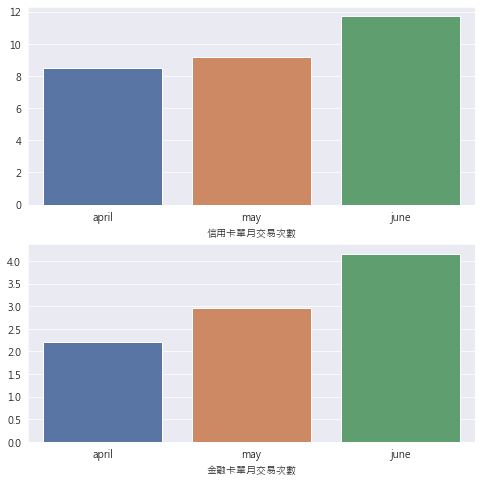

In [415]:
# 觀察信用卡 & 金融卡單月消費 [次數]
plt.figure(figsize=(8,8))

plt.subplot(211)
sns.barplot(x=["april", "may", "june"],y=[dataset["cc_count_apr"].mean(),dataset['cc_count_may'].mean(),dataset["cc_count_jun"].mean()], palette='deep')
plt.xlabel('信用卡單月交易次數')

plt.subplot(212)
sns.barplot(x=["april", "may", "june"],y=[dataset["dc_count_apr"].mean(),dataset['dc_count_may'].mean(),dataset["dc_count_jun"].mean()], palette='deep')
plt.xlabel('金融卡單月交易次數')

plt.show()

<AxesSubplot:xlabel='Total_investement', ylabel='cc_cons'>

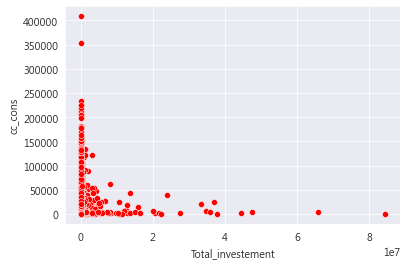

In [416]:
# 合併各項投資
dataset["Total_investement"] = dataset["investment_1"] + dataset['investment_2'] + dataset['investment_3']+ dataset['investment_4']
sns.scatterplot(data = dataset, x ="Total_investement" , y = "cc_cons", color="r")

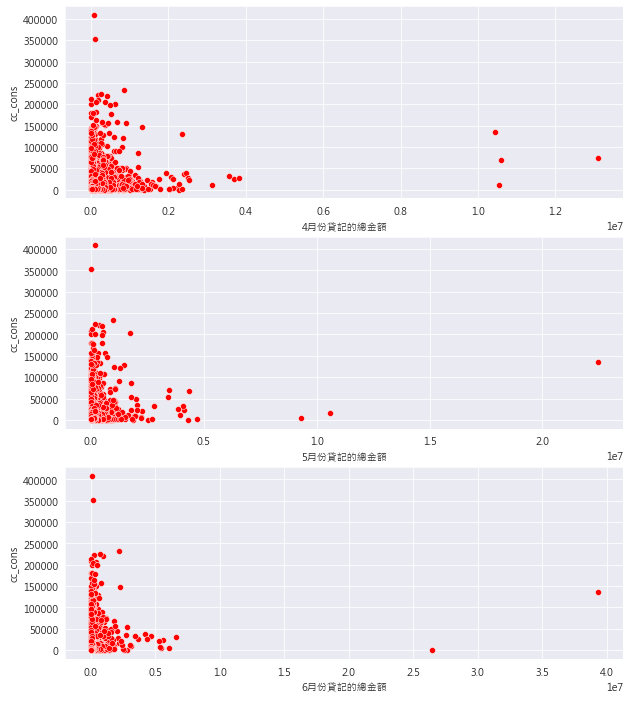

In [417]:
plt.figure(figsize=(10,12))

plt.subplot(311)
sns.scatterplot(data = dataset, x ="credit_amount_apr" , y = "cc_cons", color="r")
plt.xlabel('4月份貸記的總金額')
plt.subplot(312)
sns.scatterplot(data = dataset, x ="credit_amount_may" , y = "cc_cons", color="r")
plt.xlabel('5月份貸記的總金額')
plt.subplot(313)
sns.scatterplot(data = dataset, x ="credit_amount_jun" , y = "cc_cons", color="r")
plt.xlabel('6月份貸記的總金額')
plt.show()

## 特徵工程
>1. 特徵建構: 從原始數據中人工的構建新的特徵，取代原始數據的特徵  
>2. 特徵提取: 將機器學習演算法不能識別的原始數據，轉化為演算法可以識別的特徵
    - 特徵提取的首要任務是將變數從文字轉換成數字，連續數值轉為離散數值，以利統計與導入演算法模型
>3. 特徵選擇: 從所有的特徵中選擇一組最好的特徵集，捨去無關的特徵，保留相關性高的特徵
    - 使用相關性作圖(Pearson相關係數)，顏色較淺的部分為沒有關係的，顏色偏藍就是正相關，顏色偏紅就是負相關，而我們在意的是與poi有相關性無論正負，若是值越接近0，即是要被剃除的特徵。

### 1. 特徵建構

In [418]:
# Total 三個月信用卡消費金額
dataset["Total_cc_cons"] = dataset['cc_cons_apr'] + dataset['cc_cons_may'] + dataset['cc_cons_jun']

# Total 三個月金融卡消費金額
dataset["Total_dc_cons"] = dataset['dc_cons_apr'] + dataset['dc_cons_may'] + dataset['dc_cons_jun']

# Total 三個月信用卡交易次數
dataset["Total_cc_count"] = dataset['cc_count_apr'] + dataset['cc_count_may'] + dataset['cc_count_jun']

# Total 三個月金融卡交易次數
dataset["Total_dc_count"] = dataset['dc_count_apr'] + dataset['dc_count_may'] + dataset['dc_count_jun']

# Total 有效貸款
dataset["Totat_active_loan"]= dataset['personal_loan_active'] + dataset['vehicle_loan_active']

# Total 投資金額 
dataset["Total_investement"] = dataset["investment_1"] + dataset['investment_2'] + dataset['investment_3'] + dataset['investment_4']

# Total 貸記金額
dataset["Total_credit_amount"] = dataset['credit_amount_apr'] + dataset['credit_amount_may'] + dataset['credit_amount_jun']

# Total 借記金額
dataset["Total_debit_amount"] = dataset['debit_amount_apr'] + dataset['debit_amount_may'] + dataset['debit_amount_jun']

# Total 最大貸記金額
dataset["Total_max_credit_acmout"] = dataset['max_credit_amount_apr'] + dataset['max_credit_amount_may'] + dataset['max_credit_amount_jun']

### 2. 特徵提取

In [419]:
# 對分類目標做標籤化處理
dataset['account_type'] = LabelEncoder().fit_transform(dataset['account_type'])
dataset['gender'] = LabelEncoder().fit_transform(dataset['gender'])
dataset['loan_enq'] = LabelEncoder().fit_transform(dataset['loan_enq'])

dataset.head()

,account_type,gender,age,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active,cc_cons,Total_investement,Total_cc_cons,Total_dc_cons,Total_cc_count,Total_dc_count,Totat_active_loan,Total_credit_amount,Total_debit_amount,Total_max_credit_acmout
0,1,1,63.0,7695.0,0.0,479.0,0.0,622.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,150000.0,0.0,0.0,0.0,0.0,0.0,118845.2,50000.0,0.0,51205.47,50259.0,3.0,1.0,50000.0,24740.22,114252.0,3.0,2.0,45000.0,20215.85,1279.37,7.0,3.0,470.0,0,0.0,435,168845.2,8796.0,0.0,6.0,0.0,0.0,165790.37,96161.54000000001,95470.0
1,0,1,33.0,52702.0,988.72,29873.0,0.0,1087.0,2806.24,11.0,14.0,11.0,1.0,0.0,6.0,176000.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,159050.76,169812.0,20.0,9.0,70000.0,103102.85,174606.0,6.0,10.0,150000.0,122037.66,55390.0,8.0,19.0,27000.0,0,4963.33,1921,0.0,83662.0,3794.96,36.0,7.0,0.0,399808.0,384191.27,247000.0
2,0,1,44.0,10800.49,3215.52,21660.0,1607.0,1168.0,355.0,6.0,9.0,6.0,3.0,2.0,14.0,65000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51484.55,38942.0,16.0,4.0,11700.0,15283.0,23051.0,2.0,7.0,13800.0,46827.0,29297.91,6.0,19.0,20800.0,0,0.0,1970,0.0,33628.49,5177.52,21.0,19.0,0.0,91290.91,113594.55,46300.0
3,1,1,44.0,20936.0,0.0,2094.0,0.0,11778.5,0.0,9.0,6.0,6.0,0.0,0.0,0.0,600000.0,0.0,0.0,0.0,0.0,0.0,132442.0,0.0,0.0,1981.07,2294.0,2.0,1.0,2000.0,19361.24,19529.0,1.0,1.0,19300.0,5426.55,7544.0,3.0,1.0,5300.0,0,1238.18,21579,132442.0,34808.5,0.0,21.0,0.0,0.0,29367.0,26768.86,26600.0
4,1,0,35.0,1183.83,0.0,3656.29,0.0,945.0,0.0,2.0,7.0,9.0,0.0,0.0,0.0,100000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6462.0,10271.0,6.0,1.0,10000.0,7461.0,3194.0,2.0,3.0,3000.0,26178.05,53483.0,4.0,4.0,45000.0,0,0.0,1814,0.0,5785.12,0.0,18.0,0.0,0.0,66948.0,40101.05,58000.0


### 3. 特徵選擇

In [420]:
# 觀察相關性
dataset.astype(float).corr()['cc_cons'].sort_values()

gender                     -0.028836017803888697
dc_count_jun               -0.014606633497179718
Total_dc_count             -0.011969152464857068
debit_count_apr            -0.011325640506839195
vehicle_loan_active        -0.010906922798182651
loan_enq                    -0.01087443366392562
dc_count_may               -0.010339470977218282
debit_count_jun            -0.007527287170663614
dc_count_apr              -0.0050159843590341655
debit_count_may            0.0008001606838248776
investment_4                 0.00551936936169518
investment_1                0.007145408017760425
credit_count_jun            0.010512276997374953
Total_investement             0.0149454393461169
Totat_active_loan           0.015139563895635599
personal_loan_active        0.023855899340280956
dc_cons_apr                 0.027867661497848438
credit_count_apr             0.03231123869331169
credit_count_may            0.032738370454130146
dc_cons_jun                 0.040245520571476866
dc_cons_may         

In [421]:
# 取得相關性絕對值大於 0.1 的特徵
feature_select = []
for i in range(len(dataset.astype(float).corr()['cc_cons'])):
    if abs(dataset.astype(float).corr()['cc_cons'].values[i] >= 0.1):
        feature_select.append(dataset.astype(float).corr()['cc_cons'].index[i])

# 刪除較不相關的欄位
for column in dataset.columns:
    if column not in feature_select:
        dataset = dataset.drop([column], axis = 1)
        
# 觀察修正後的訓練資料尺寸
print(f'dataset shape: {dataset.shape}')

dataset shape: (32820, 23)


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

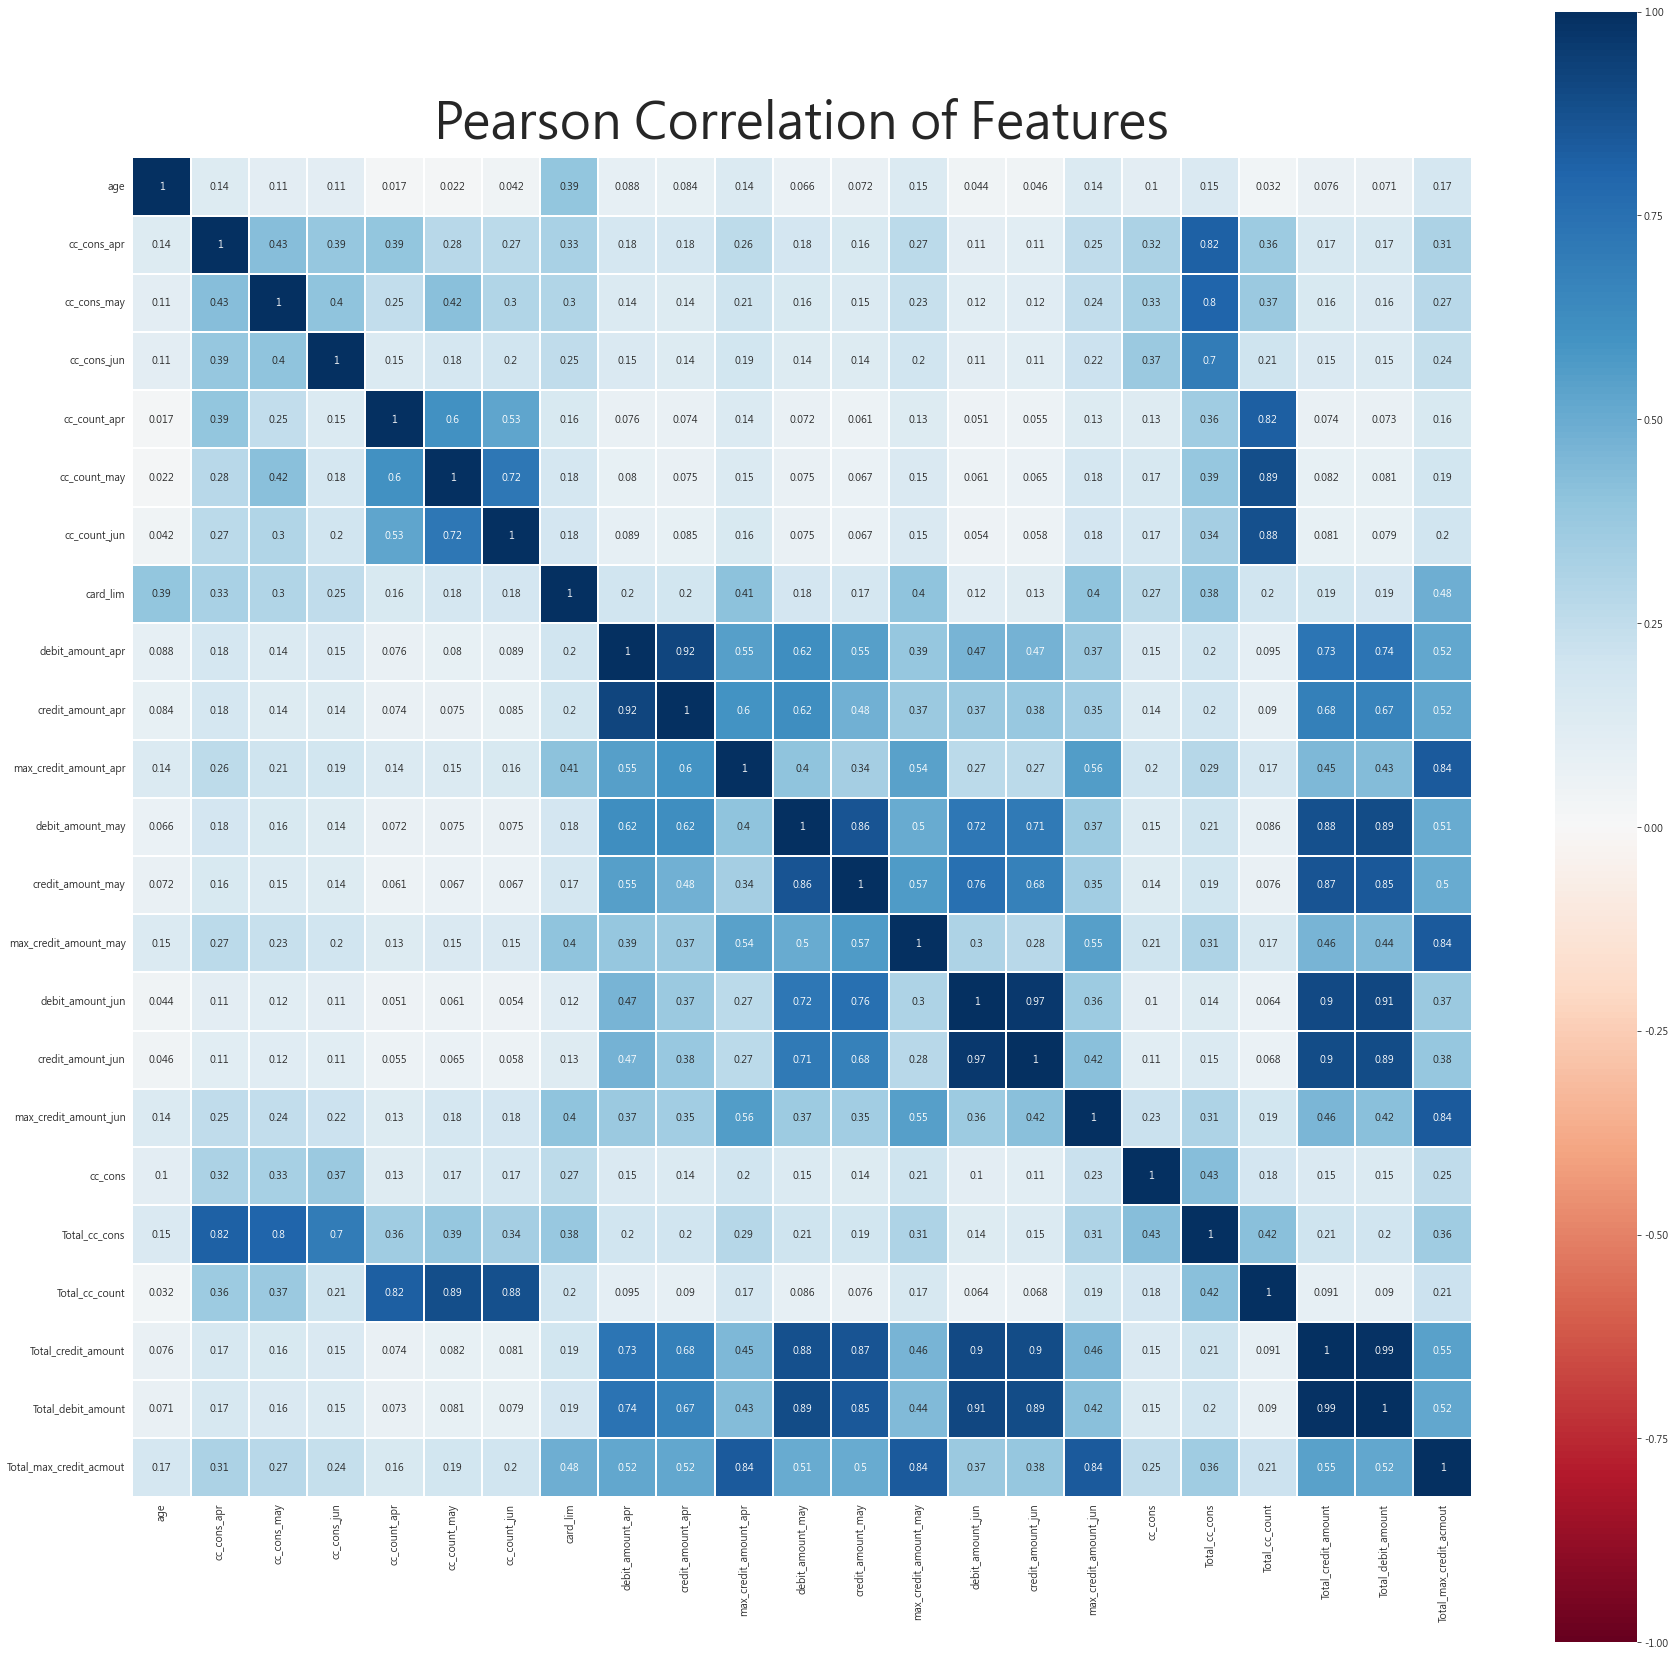

In [422]:
# 先建立空圖
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 30))
plt.title('Pearson Correlation of Features', y = 1.01, size = 50)

# 再將資料加入圖中
sns.heatmap(dataset.astype(float).corr(), linewidths = 0.1, vmin = -1.0 ,vmax = 1.0, square = True, cmap = colormap, 
            linecolor = 'white', annot = True, xticklabels = True, yticklabels = True)

## 準備訓練資料

In [423]:
# 訓練資料處理
y = dataset['cc_cons']
X = dataset.drop(['cc_cons'], axis = 1) # 刪除指定column

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X shape: (32820, 22)
y shape: (32820,)


In [424]:
# 將資料分割成訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [425]:
# 特徵縮放
# sc = MinMaxScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# X_train_StandardScaler = pd.DataFrame(X_train)
# X_train_StandardScaler.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.36734693877551017,0.03536697028395399,0.012759274520190846,0.03355601541852941,0.02824858757062147,0.016638935108153077,0.0444104134762634,0.08199908199908199,0.005944951397032458,0.007349214916618596,0.048,0.006823362693277596,0.0044491583417038075,0.040999999999999995,0.0023791545871632226,0.0020250293524133748,0.048,0.03753067684301355,0.029164329781267526,0.006384318812719762,0.006749715760456646,0.04566666666666667
1,0.0,0.01742362428175934,0.0017246582159412922,0.01612153942817447,0.005649717514124294,0.0016638935108153079,0.0030627871362940277,0.029999029999029998,0.0014116891348381034,0.0012892181973886197,0.016581009999999997,0.0013101868757171714,0.0016339756770321577,0.016901,0.0010063701342071967,0.0002875954991278695,0.005,0.015740566248214887,0.0022434099831744247,0.0013551215990241954,0.0018805015206265626,0.012827336666666666
2,0.16326530612244894,0.003476064300561584,0.006021071494524385,0.01169863825207635,0.0018832391713747645,0.0,0.007656967840735069,0.034999034999035,0.0008841627012201623,0.0008517697265839237,0.005,0.0006860772668649175,0.002295928718931188,0.024,0.0011001067750838135,0.0013710990740791497,0.02,0.00920807151785473,0.0022434099831744247,0.0023259900384587787,0.0015369846480496276,0.016333333333333335
3,0.346938775510204,0.010911504938593566,0.006282017609725927,0.003346982702276264,0.011299435028248588,0.014975041597337771,0.02450229709035222,0.07099907099907099,0.0033677415853386704,0.0033208445761535956,0.036211,0.0035716189394876248,0.0034254725328811313,0.036211,0.0019282748290143355,0.0020153598416288512,0.036209,0.01059716659508049,0.016264722378014584,0.004314504999361832,0.004225977310523206,0.03621033333333334
4,0.18367346938775508,0.0816566688798216,0.024841071330382204,0.020633501946564915,0.011299435028248588,0.0033277870216306157,0.026033690658499236,0.27499927499927496,0.016309060213407247,0.01603012629285277,0.205,0.003202952513217773,0.0034670694429758714,0.03,0.001011738448558477,0.0008459735708055867,0.0172,0.0651385075894744,0.012899607403252944,0.00872057290379637,0.008737022405456318,0.08406666666666668


## 建立模型

### 1. Linear Regression 線性迴歸

In [426]:
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(X_train,y_train)
print('Linear Regression Training score:', model_LinearRegression.score(X_train, y_train) * 100)
y_test_predict = model_LinearRegression.predict(X_test)
r2_score(y_test, y_test_predict)

Linear Regression Training score: 21.478945363537527


0.21165771339942474

### 2. Support Vector Machines 

In [427]:
rf = RandomForestRegressor(n_estimators=1000, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=10, bootstrap=False)

rf.fit(X_train, y_train)
print('rf Training score:', rf.score(X_train, y_train) * 100)
y_test_predict = rf.predict(X_test)
r2_score(y_test, y_test_predict)

rf Training score: 41.01303089816039


0.21489195051801047

In [428]:
from lightgbm import LGBMRegressor
fit_params ={'early_stopping_rounds':10,
            'eval_metric':'rmse',
            'eval_set':[(X_test,y_test)],
            'eval_names':['valid'],
            'verbose':100}
lgb = LGBMRegressor(max_depth=50,learning_rate =0.01,n_estimators=10000)

lgb.fit(X_train, y_train, **fit_params)
y_pred_test = lgb.predict(X_test)
r2_score(y_test, y_pred_test)

[100]	valid's rmse: 11322.8	valid's l2: 1.28205e+08
[200]	valid's rmse: 11188.2	valid's l2: 1.25175e+08


0.1925329037856769

In [429]:
y_test_predict = rf.predict(aaa)
y_test_predict

ValueError: could not convert string to float: 'saving'